<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
        Project - 3rd Phase
        <br />
        Image Colorization using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = 99101773
            <br />
            Name = Mohammad Ali   
            <br />
            Last_Name = SharifiMehr
        </div>
        <div class="column">
        <br />
            student_number = 99101608
            <br />
            Name = Melika    
            <br />
            Last_Name = Rajabi
        </div>
    </font>
    </div>


1. Download the "landscape image colorization" dataset and slice it to `train_set`, `validation_set` and `test_set`.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to colorize grayscale images
3. plot learning curve and visualize grayscale images of test set, their corresponding color images and their colorized versions side by side.

# Import Necessary Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import random
from torchvision.io import read_image
from torch.nn import functional as F
import torch
from skimage.color import rgb2lab, lab2rgb
from torchvision.transforms import transforms
import torch.nn as nn
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

First of all, we import the required libraries for the rest of the code.

- os: For managing the download process and working with paths and folders of the dataset.

- matplotlib: For working with images of the dataset and managing the visualization.

- random: For handling the index random choosing process for preventing the bias in the datasets.

- read_image: To read the images into a $3$ dimensional RGB or grayscale Tensor.

- functional: To use functions such as "interpolate" or "relu".

- torch: For managing general operations required for creating the autoencoder.

- rgb2lab, lab2rgb:  For converting the RGB and Lab spaces to eachother. Note that Lab is another color space that represents the Lightness, amount of red-green and amount of blue-yellow in each picture. L is between $0$ to $100$ and a and b are between $-128$ to $127$.

- transforms: In order to use the transforms required in the rest of the project.

- torch.nn: For using the functions and operations required to create our neural network.

- summary: In order to observe the summary of the model we've created and the shapes of the layers' inputs and outputs.

- tqdm: To display a progress bar, which shows the progress of an iteration or computation. It provides a visual indication of the completion status and the estimated time remaining for the loop to finish.

- DataLoader: To load the data from the dataset based on the size of batches, shuffling and etc. we give to it.

- Dataset: To load the data from the Files.

# Load Dataset and Prepare It

In [2]:

# Installing "Kaggle" and linking to my account
! pip install kaggle

os.environ['KAGGLE_USERNAME'] = 'melikarajabi'
os.environ['KAGGLE_KEY'] = 'c9fb5493774daa6c543933f4906d3aec'

# Downlodaing the mentioned dataset
! kaggle datasets download theblackmamba31/landscape-image-colorization

# Unzipping the downloaded dataset
!unzip '*.zip'


Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

Color image Size:  (150, 150, 3)
Gray image Size:  (150, 150)


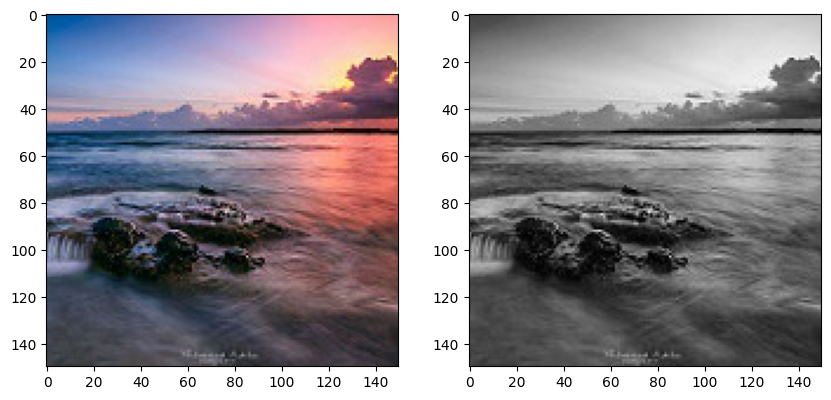

In [3]:

# Defining the paths through the images of the dataset
base_dir = '/content/landscape Images'
color_dir = os.path.join(base_dir, 'color')
gray_dir = os.path.join(base_dir, 'gray')

# Converting the images into arrays
color_img = plt.imread(os.path.join(color_dir, '3564.jpg'))
gray_img = plt.imread(os.path.join(gray_dir, '3564.jpg'))

# Getting familiar with the dataset by Printing their dimensions & Plotting examples
print("Color image Size: ", color_img.shape)
print("Gray image Size: ", gray_img.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(color_img)
ax[1].imshow(gray_img, cmap='gray')
plt.show()


By using the "path.join" command, we can connect the paths to eachother.

"imread" reads the given image and transforms it to an array.

As we see, the color images form $150 \times 150 \times 3$ arrays and gray images form $150 \times 150$ arrays. That is beacause color images contain $3$ values for each pixel representing R, G, B. (Note that not all the images have the first dimension of $150$, but most of them are as though.)

We have used "imshow" to plot the images. Note that by default, "imshow" maps grayscale values to a colormap called "viridis", which represents lower values as blue and higher values as green/yellow. To display the grayscale images without any color mapping, we specify the colormap explicitly as "gray" using the "cmap" parameter of imshow.

In [4]:

# Defining a class which loads grayscale images and their corresponding color images,
# preprocesses them and returns the preprocessed image and label pairs as outputs.
class Preprocessor(Dataset):

  def __init__(self, indices, base_dir, transform=None):

    self.indices = indices
    self.base_dir = base_dir
    self.transform = transform

    color_dir = os.path.join(base_dir, 'color')
    gray_dir = os.path.join(base_dir, 'gray')
    self.color_path = color_dir
    self.gray_path = gray_dir

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):

    # Defining the desired size of images
    d = 160
    img_name = str(idx) + '.jpg'

    image = read_image(os.path.join(self.gray_path, img_name))
    image = image.unsqueeze(0)
    image = F.interpolate(image,(d, d))
    image = image.squeeze(0)
    image = image.permute(1,2,0)
    image = image.repeat(1,1,3)
    image = image.permute(2,0,1)

    label = read_image(os.path.join(self.color_path, img_name))
    label = label.unsqueeze(0)
    label = F.interpolate(label,(d, d))
    label = label.squeeze(0)
    label = label.permute(1,2,0)
    label = label.permute(2,0,1)

    image = torch.tensor(rgb2lab(image.permute(1,2,0)/255))
    label = torch.tensor(rgb2lab(label.permute(1,2,0)/255))

    image = (image + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
    label = (label + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])

    image = image.permute(2,0,1)
    label = label.permute(2,0,1)

    image = image[:1,:,:]
    label = label[1:,:,:]

    return image, label


Here we define a class which inherits from the "Dataset" class in PyTorch.

- In the constructor ("\_\_init\_\_" method), we initialize various instance variables, including the indices ("indices"), base directory ("base_dir"), transformation ("transform"),  and paths to the color and grayscale image directories ("color_path" and "gray_path").

- The "\_\_len\_\_" method returns the length of the dataset, which is the number of indices provided during initialization.

- The "\_\_getitem\_\_" method is called to retrieve an item from the dataset at a given index ("idx"). The method performs the following steps:

  - Constructs the image name by appending the index with the ".jpg" extension.

  - Reads the grayscale image from the gray image directory ("self.gray_path") using the "read_image()" function.
  - Adds a new dimension at the specified index ($0$) to the image tensor using "unsqueeze()" command. It effectively converts a $3$-dimensional tensor of shape $(C, H, W)$ to a $4$-dimensional tensor of shape $(1, C, H, W)$. The added dimension represents the batch dimension.
  - Resizes the image tensor to a desired size $(160 \times 160)$ using "interpolate()" command. This resizing operation is performed using an interpolation algorithm that maintains the aspect ratio of the original image.
  - Removes the singleton dimension (dimension of size $1$) at index $0$ from the image tensor. This operation is performed to remove the batch dimension when it's no longer needed.
  - Permutes/reorders the dimensions of the image tensor using "permute()" command. It rearranges the dimensions from the original order (channel, height, width) to the specified order (height, width, channel). This operation is required to match the desired dimension order for further processing and compatibility with certain operations.
  - Repeats the image tensor along the specified dimensions using "repeat()" command. It creates three copies of the tensor along the third dimension (channel dimension) so that the grayscale image is expanded into a three-channel image.
  - Rearranges the dimensions from the current order (height, width, channel) to the desired order (channel, height, width).

  - Reads the corresponding color image from the color image directory ("self.color_path") and performs similar preprocessing steps for the color image.

  - Normalizes the image and label tensors so that the numbers are in [0, 1].
  - Converts the RGB images to the Lab color space using the "rgb2lab()" function and converts them to tensors.
  - Normalizes the new tensors by first adding $128$ to the second and third dimensions and then deviding the first dimension by $100$ and the second and third dimensions by $255$. In this way the numbers are in [0, 1]. Recall the interval of Lab dimensions.
  - Selects the L channel (grayscale image) from the Lab image as the input (image) and the ab channels (color channels) as the target (label).
  - Returns the preprocessed image and label as tensors.

In [5]:

# Indicating the proportion of sets from the total dataset
train_ratio = 0.75
test_ratio = 0.125

# Counting the number of total images
N = len(os.listdir(color_dir))

# Randomly shuffling the numbers in total images' range
random_indices = random.sample(list(range(N)), N)

# Slicing the numbers between the train, test and validation sets based on their ratios
train_nums = round(N * train_ratio)
train_indices = random_indices[:train_nums]
test_nums = round(N * test_ratio)
test_indices = random_indices[train_nums:train_nums+test_nums]
validation_indices = random_indices[train_nums+test_nums:]

print("train set Size: ", len(train_indices))
print("test set Size: ", len(test_indices))
print("validation set Size: ", len(validation_indices))


train set Size:  5347
test set Size:  891
validation set Size:  891


First of all we indicate the amount of total dataset that we would like to dedicate to train, test and validation set.

By using "listdir" command, we list all the files in a path. Here it lists all the images in the given path which can be either color or gray directories of the dataset.

In the next step we shuffle a sequence of numbers from $0$ to $N$. These are representing the indices. Then we assign each portion of the shuffled indices to train, test or validation set based on their ratios.

Note that the "random.sample()" function randomly selects unique elements from a population (in this case, a list of indices) without replacement.

In [6]:

# Defining the transforms
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()]
)

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()]
)

validation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()]
)


Here we define $3$ transformation pipelines using the "transforms.Compose()" function. It is used to create a sequence of transformations to be applied to the input data in a specific order. It takes a list of transformations as input and returns a new transformation pipeline that applies the transformations sequentially.

The "ToPILImage()" transform converts a tensor or an array-like object representing an image into a PIL (Python Imaging Library) image. It expects the input to be a tensor or an array-like object with dimensions representing the image (e.g. shape: $C \times H \times W$ for a color image, or $H \times W$ for a grayscale image).

The "ToTensor()" transform does the reverse operation of "ToPILImage()". It converts a PIL image or an array-like object representing an image into a PyTorch tensor. It expects the input to be a PIL image or an array-like object compatible with PIL.

In [7]:

# Applying the preprocessing class functions to the images using the indices and transforms defined earlier
train_dataset = Preprocessor(indices = train_indices, base_dir = base_dir, transform=train_transforms)
test_dataset = Preprocessor(indices = test_indices, base_dir = base_dir, transform=test_transforms)
validation_dataset = Preprocessor(indices = validation_indices, base_dir = base_dir, transform=validation_transforms)

# Loading the train, test and validation sets with the desired batch sizes and shuffling=True because all sets are indicated by ourselves
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)


In [9]:

# Observing the shape of the images after preprocessings
image, label = next(iter(train_loader))
sample_image, sample_label = image[0], label[0]
print("Sample image Shape: ", sample_image.shape, "Sample label Shape: ", sample_label.shape)


Sample image Shape:  torch.Size([1, 160, 160]) Sample label Shape:  torch.Size([2, 160, 160])


Note that "iter()" creates an iterator that allows sequential access to the batches of data in the training dataset. "next()" fetches the next batch of data.

# Define Your Model

In [10]:

class Autoencoder(nn.Module):

  def __init__(self):

    super(Autoencoder, self).__init__()

    # Encoder
    self.conv1 = nn.Conv2d(1, 64, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
    self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
    self.pool = nn.MaxPool2d(2, 2)

    # Decoder
    self.t_conv1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
    self.t_conv2 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
    self.t_conv3 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1)
    self.t_conv4 = nn.ConvTranspose2d(192, 15, 3, stride=1, padding=1)
    self.dropout = nn.Dropout(0.2)
    self.converge = nn.Conv2d(16, 2, 3, stride=1, padding=1)

  def forward(self, x):

    x1 = F.relu(self.conv1(x))
    x2 = F.relu(self.conv2(x1))
    x3 = F.relu(self.conv3(x2))
    x4 = F.relu(self.conv4(x3))
    xd = F.relu(self.t_conv1(x4))
    xd = torch.cat((xd, x3), dim=1)
    xd = self.dropout(xd)
    xd = F.relu(self.t_conv2(xd))
    xd = torch.cat((xd, x2), dim=1)
    xd = self.dropout(xd)
    xd = F.relu(self.t_conv3(xd))
    xd = torch.cat((xd, x1), dim=1)
    xd = self.dropout(xd)
    xd = F.relu(self.t_conv4(xd))
    xd = torch.cat((xd, x), dim=1)
    x_out = F.relu(self.converge(xd))

    return x_out


An autoencoder is a type of neural network that aims to learn a compressed representation of the input data and reconstruct it as accurately as possible.

In this step, we define a class named "Autoencoder" that serves as a PyTorch module for an autoencoder network. At the beginning we indicate that the class inherits from the "nn.Module" class in PyTorch. By inheriting from "nn.Module", the class gains all the functionalities and properties of a PyTorch module.

By calling "super(Autoencoder, self).\_\_init\_\_()", the "\_\_init\_\_" method of the parent class (nn.Module) is executed. This allows any necessary initialization procedures defined in the parent class to be executed before performing any additional initialization specific to the Autoencoder class.

"def \_\_init\_\_(self)": This is the constructor method of the class. It initializes the layers and components of the autoencoder network. The layers consist of an encoder and a decoder section. The encoder is responsible for compressing the input data into a lower-dimensional representation, while the decoder aims to reconstruct the original input from the compressed representation.

These layers include convolutional layers ("self.conv1", "self.conv2", "self.conv3", "self.conv4"), max pooling ("self.pool"), transpose convolutional layers ("self.t_conv1", "self.t_conv2", "self.t_conv3", "self.t_conv4"), dropout ("self.dropout"), and a final convolutional layer ("self.converge").

Note that "stride" determines how much the filter shifts its position after each convolutional operation and "padding" is the addition of extra pixels or values around the border of the input image or feature map before applying the convolution operation.

"def forward(self, x)": This method defines the forward pass of the autoencoder network. It takes an input tensor "x" as input and processes it through the layers defined in the "\_\_init\_\_" method.

Mention that these are the layers we've used:

- "Conv2d": a $2D$ convolution operation

- "MaxPool2d": a $2D$ max pooling

- "ConvTranspose2d": a $2D$ transpose convolution operation, also known as deconvolution or fractionally strided convolution

- "Dropout": a regularization technique to prevent overfitting

- "relu": The rectified linear unit (ReLU) activation function

- "torch.cat": a function that concatenates tensors along a specified dimension

In [11]:

# Indicating the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:

# Storing the model on the device
model = Autoencoder()
model = model.to(device)


In [14]:

# Observing the summary of the layers and shapes of the model we created
d = 160
summary(model, input_size=(1, d, d))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 160]             640
            Conv2d-2           [-1, 64, 80, 80]          36,928
            Conv2d-3          [-1, 128, 40, 40]          73,856
            Conv2d-4          [-1, 256, 20, 20]         295,168
   ConvTranspose2d-5          [-1, 128, 40, 40]         295,040
           Dropout-6          [-1, 256, 40, 40]               0
   ConvTranspose2d-7           [-1, 64, 80, 80]         147,520
           Dropout-8          [-1, 128, 80, 80]               0
   ConvTranspose2d-9        [-1, 128, 160, 160]         147,584
          Dropout-10        [-1, 192, 160, 160]               0
  ConvTranspose2d-11         [-1, 15, 160, 160]          25,935
           Conv2d-12          [-1, 2, 160, 160]             290
Total params: 1,022,961
Trainable params: 1,022,961
Non-trainable params: 0
---------------------------

# Fit The Model

Also Define optimizer, Criterion and other parameters

In [15]:

# Specifying the learning rate and the optimizer
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Specifying the loss function
criterion = nn.MSELoss()


We use "Adam" optimizer that is a popular optimization algorithm used to update the model's parameters based on the computed gradients during backpropagation.

"model.parameters()" provides the model's parameters that need to be optimized.

Also we define the loss function as "MSE" (Mean Squared Error) between predicted and target values.

In [16]:

# Defining the number of epochs to train the model
num_epochs = 10

train_losses = []
test_losses = []

# Iterating over the epochs and training the model
for epoch in range(1, num_epochs+1):

  train_loss = 0.0
  # Iterating over the batches
  for data in tqdm(train_loader):

    # Extracting the data in each batch containing images and corresponding labels
    images, labels = data
    # Converting the images and labels to the appropriate data type and moving them to the specified device
    # (e.g. GPU) for accelerated computations, if available
    images = images.float().to(device)
    labels = labels.float().to(device)

    # Clearing the gradients of the model parameters before computing the gradients in the backward pass
    optimizer.zero_grad()

    # Feeding the input images to the model to obtain the predicted outputs
    outputs = model(images)

    # Calculating the loss
    loss = criterion(outputs, labels)
    # Computing the gradients of the model's parameters with respect to the loss, using backpropagation
    loss.backward()

    # Updating the model's parameters based on the computed gradients and the optimization algorithm
    optimizer.step()

    # Updating the cumulative training loss for the current epoch by adding the loss multiplied by the batch size
    train_loss += loss.item() * images.size(0)

  # Computing the average training loss for the current epoch by dividing the cumulative training loss by the number of batches in the training dataset
  train_loss = train_loss / len(train_loader)
  train_losses.append(train_loss)
  # Printing the epoch number and the average training loss for that epoch
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(
      epoch,
      train_loss
      ))


  test_loss = 0
  # Turning off gradients tracking for test set to save memory and computations
  with torch.no_grad():
    # Putting the model in evaluation mode, which turns off dropout and other modules that behave differently during training and evaluation
    model.eval()

    # Repeating the same process as the train set for the test set
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels)
      test_loss += loss.item() * images.size(0)

  # Setting the model back to the training mode, enabling modules like dropout that behave differently during training and evaluation
  model.train()

  test_loss = test_loss / len(test_loader)
  test_losses.append(test_loss)
  print("Test Loss: {:.3f}.. ".format(test_loss))


100%|██████████| 168/168 [01:26<00:00,  1.93it/s]


Epoch: 1 	Training Loss: 0.317882
Test Loss: 0.209.. 


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Epoch: 2 	Training Loss: 0.106743
Test Loss: 0.165.. 


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Epoch: 3 	Training Loss: 0.091885
Test Loss: 0.177.. 


100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


Epoch: 4 	Training Loss: 0.086511
Test Loss: 0.150.. 


100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


Epoch: 5 	Training Loss: 0.084134
Test Loss: 0.144.. 


100%|██████████| 168/168 [01:26<00:00,  1.93it/s]


Epoch: 6 	Training Loss: 0.081087
Test Loss: 0.144.. 


100%|██████████| 168/168 [01:27<00:00,  1.93it/s]


Epoch: 7 	Training Loss: 0.079161
Test Loss: 0.146.. 


100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


Epoch: 8 	Training Loss: 0.078638
Test Loss: 0.138.. 


100%|██████████| 168/168 [01:28<00:00,  1.89it/s]


Epoch: 9 	Training Loss: 0.077689
Test Loss: 0.138.. 


100%|██████████| 168/168 [01:27<00:00,  1.93it/s]


Epoch: 10 	Training Loss: 0.076306
Test Loss: 0.152.. 


Note that we have used "tqdm" to visualize the iteration progress.

In [17]:

# Repeating the same process on the validation set

validation_losses = []
for epoch in range(1, num_epochs+1):

  validation_loss = 0
  with torch.no_grad():

    model.eval()
    for images, labels in validation_loader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels)
      validation_loss += loss.item() * images.size(0)

  model.train()
  validation_loss = validation_loss / len(validation_loader)
  validation_losses.append(validation_loss)
  print("Validation Loss: {:.3f}.. ".format(validation_loss))


Validation Loss: 0.152.. 
Validation Loss: 0.152.. 
Validation Loss: 0.152.. 
Validation Loss: 0.152.. 
Validation Loss: 0.152.. 
Validation Loss: 0.152.. 
Validation Loss: 0.152.. 
Validation Loss: 0.152.. 
Validation Loss: 0.152.. 
Validation Loss: 0.152.. 


# Plot The Results

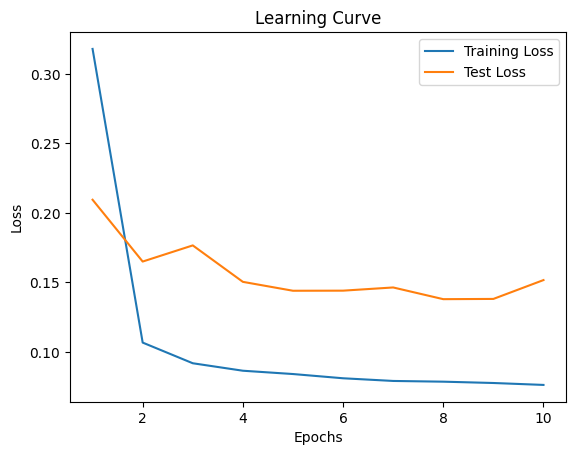

In [18]:

# Plotting the learning curve

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, test_losses, label="Test Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()

plt.show()


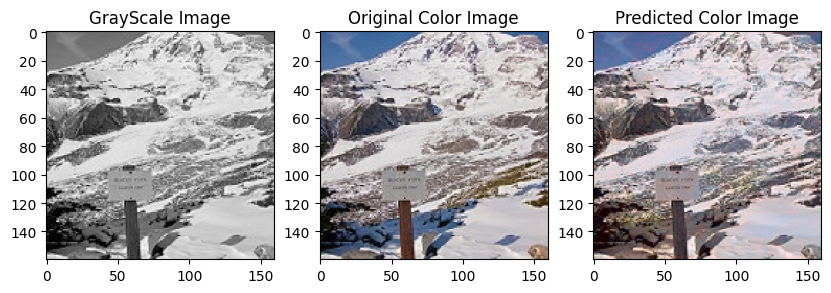

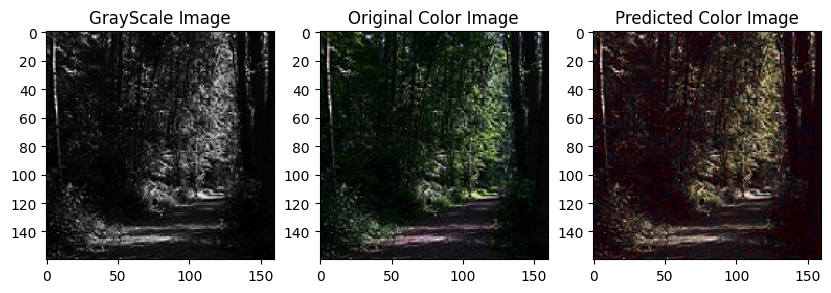

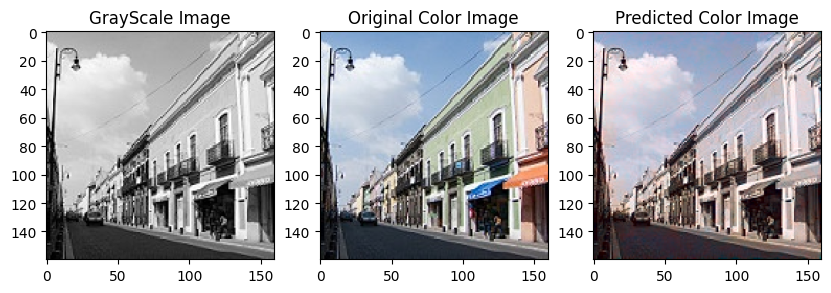

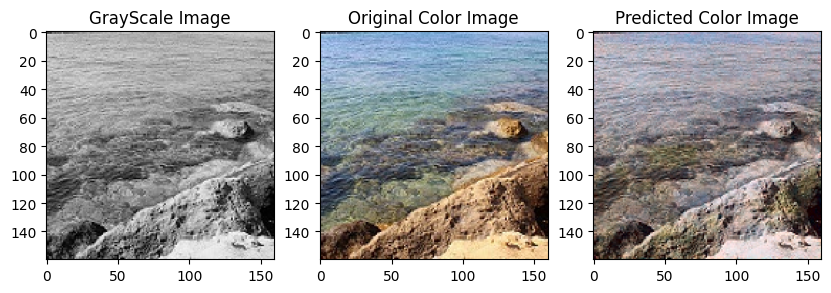

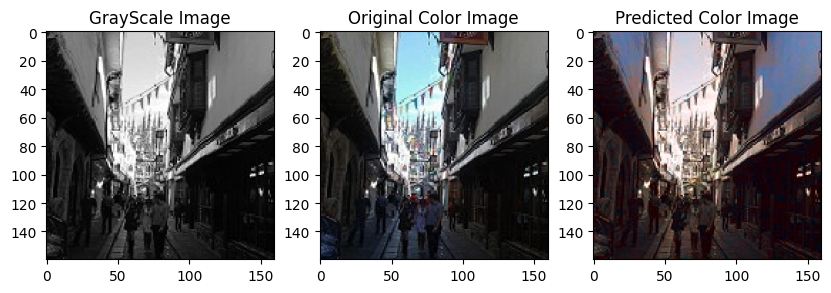

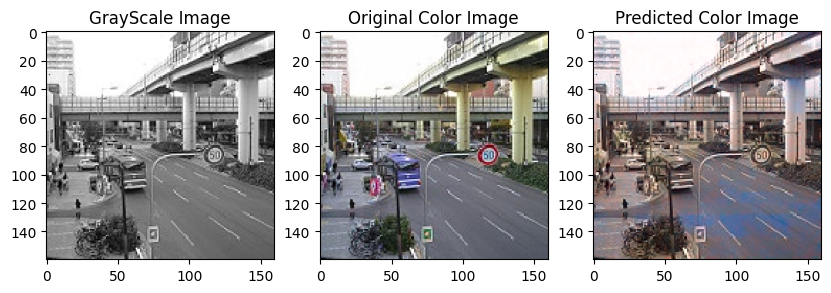

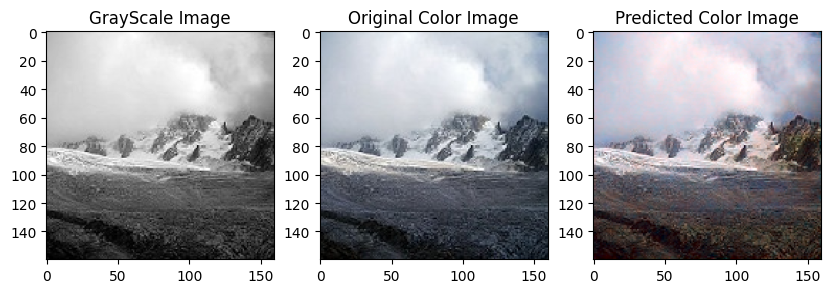

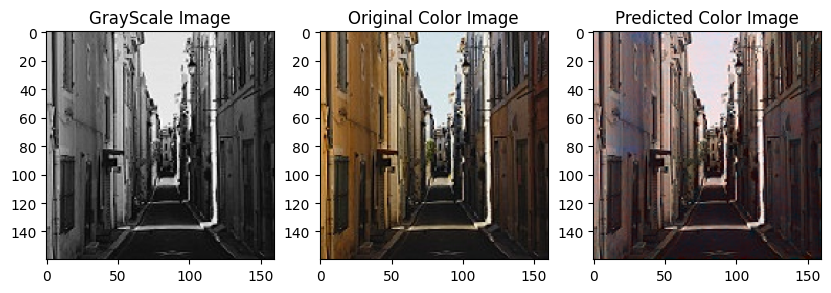

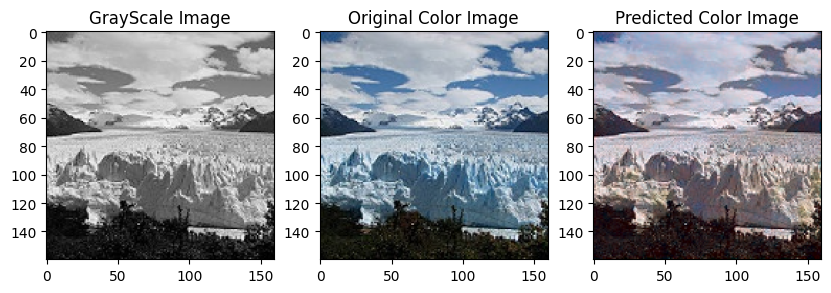

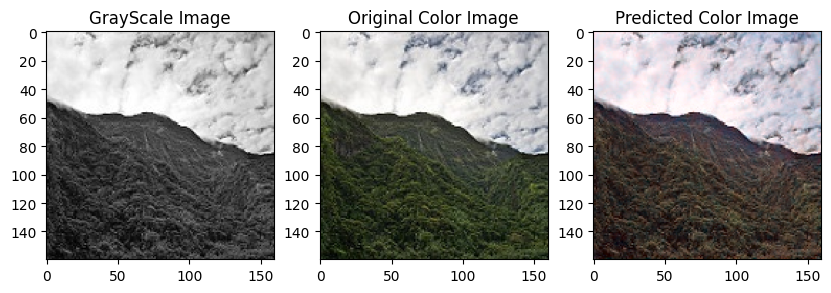

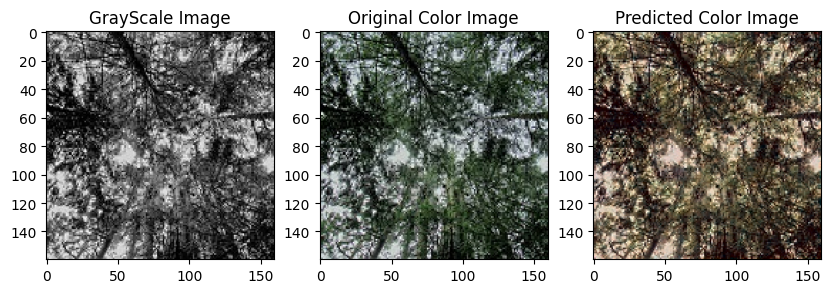

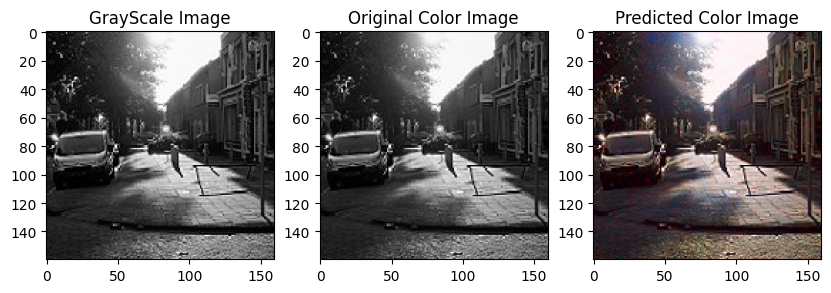

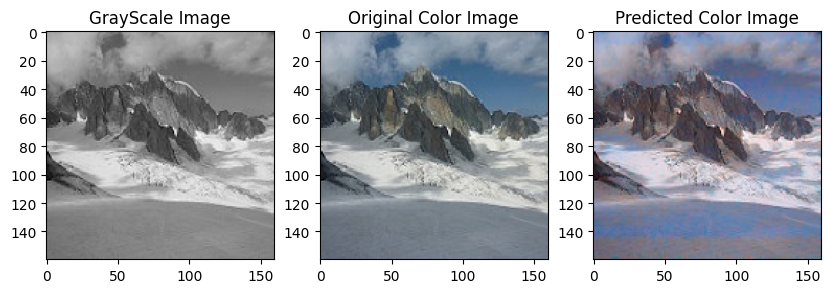

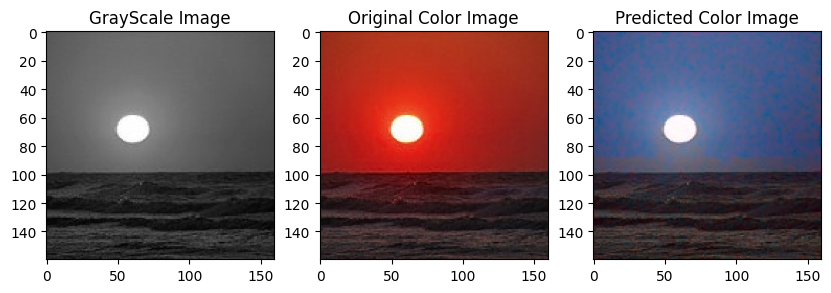

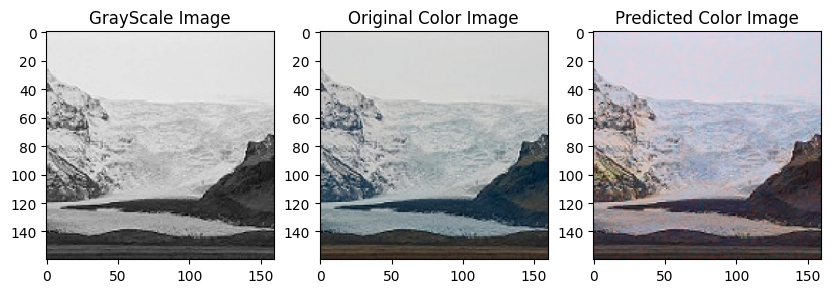

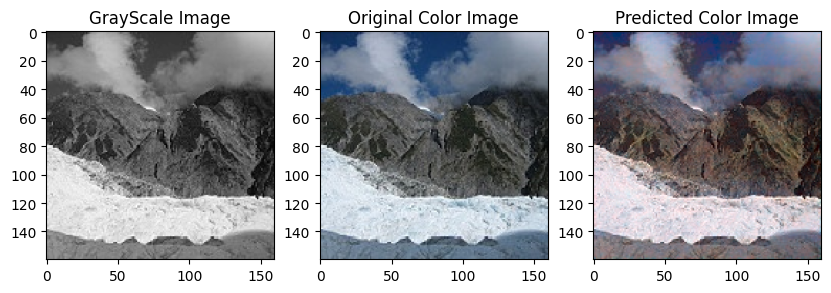

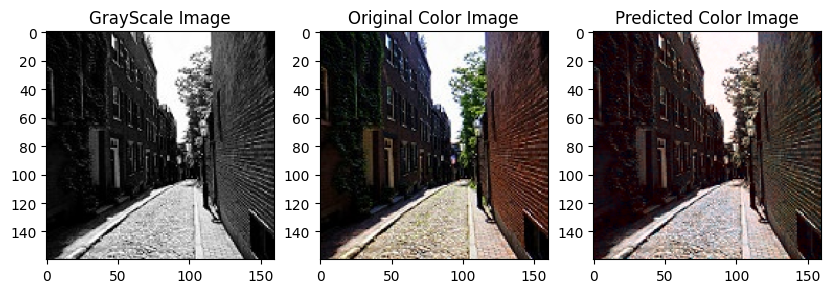

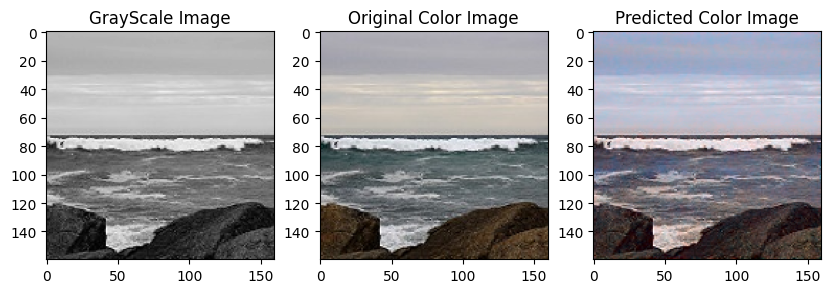

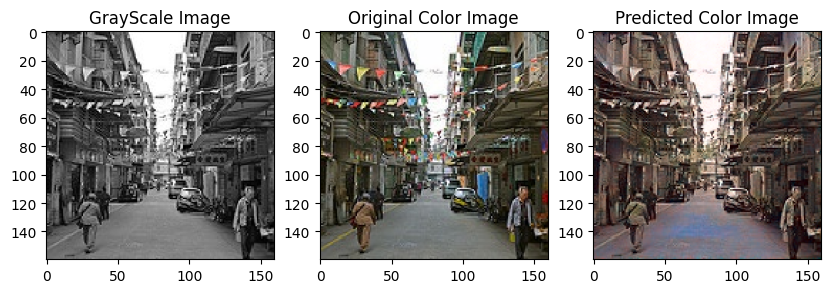

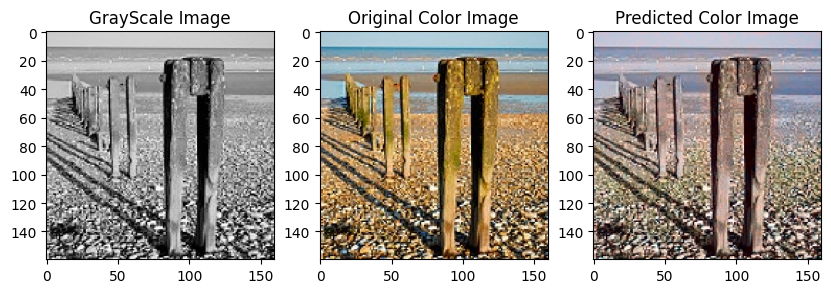

In [20]:

# The dimension of images
d = 160

# Tracking the iteration number (image count)
n = 0
while n < 20:

  # Retrieving a batch of validation data from the loader
  validation_img, validation_label = next(iter(validation_loader))

  # Passing the first image from the batch through the model to obtain the predicted output
  pred = model.forward(validation_img[0].float().cuda().view(1, 1, d, d))

  # Concatenating the original grayscale image (validation_img[0]) and the predicted color image (pred[0].cpu()) along the specified dimension (dim=0)
  lab_pred = torch.cat((validation_img[0].view(1, d, d), pred[0].cpu()), dim=0)
  # Unnormalizing the numbers of the resulted tensor in order to have an appropriate numbers representing an image
  lab_pred_inv_scaled = lab_pred.permute(1, 2, 0) * torch.tensor([100, 255, 255]) - torch.tensor([0, 128, 128])
  # Reconverting the tensor from lab space to RGB space
  rgb_pred = lab2rgb(lab_pred_inv_scaled.detach().numpy())

  # Preparing the original color image for visualization
  lab_original = torch.cat((validation_img[0].view(1, d, d), validation_label[0].view(2, d, d)), dim=0)
  lab_original_inv_scaled = lab_original.permute(1, 2, 0) * torch.tensor([100, 255, 255]) - torch.tensor([0, 128, 128])
  rgb_original = lab2rgb(lab_original_inv_scaled.detach().numpy())

  # Visualizing the predicted and originl images
  fig = plt.figure(figsize=(10, 10))

  plt.subplot(1, 3, 1)
  plt.imshow(validation_img[0].permute(1, 2, 0), cmap='gray')
  plt.title("GrayScale Image")

  plt.subplot(1, 3, 2)
  plt.imshow(rgb_original)
  plt.title("Original Color Image")

  plt.subplot(1, 3, 3)
  plt.imshow(rgb_pred)
  plt.title("Predicted Color Image")

  plt.show()

  n += 1


Note that to pass the input image through the model we apply the "forward()" method of the model to the input image, which is first converted to the appropriate data type (float) and moved to the GPU (cuda()) if available. The image is also reshaped to have a batch size of $1$ and dimensions $(1, 1, 160, 160)$ to match the model's expected input shape.

When concatenating the images we create a tensor "lab_pred" with $2$ channels, where the first channel represents the grayscale image, and the second channel represents the predicted color image.

Mention that "detach()" method in PyTorch is used to separate a tensor from the computational graph by returning a new tensor that doesn't require a gradient. If we want to move a tensor from the Graphical Processing Unit (GPU) to the Central Processing Unit (CPU), then we can use "detach()" method.

